Color moments

In [19]:
import cv2
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt

# === Funzione: Crop automatico dell'area informativa (cervello) ===
def crop_to_brain(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    cropped = img[y:y+h, x:x+w]
    return cropped

# === Funzione: Estrazione Color Moments su griglia 10x10 ===
def extract_color_moments(img_path):
    print("[CM10x10] Estrazione in corso...")

    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"[ERRORE] Immagine non trovata: {img_path}")

    if len(img.shape) == 2 or img.shape[2] == 1:
        print("[CM10x10] Immagine in scala di grigi – conversione in RGB finto")
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = crop_to_brain(img)  # Crop dell'area utile
    img = cv2.resize(img, (300, 100))

    h, w, _ = img.shape
    grid_h, grid_w = h // 10, w // 10
    features = []

    for i in range(10):
        for j in range(10):
            cell = img[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
            for channel in range(3):  # R, G, B
                pixels = cell[:, :, channel].flatten()
                if np.std(pixels) > 0:
                    mean = np.mean(pixels)
                    std = np.std(pixels)
                    sk = skew(pixels)
                    if np.isnan(sk):
                        sk = 0
                else:
                    mean, std, sk = 0, 0, 0
                features.extend([mean, std, sk])

    features = np.array(features)
    features = np.nan_to_num(features)

    print(f"[CM10x10] Feature vector (dim {features.shape[0]}): {features[:10]}")
    return features

# === Percorso immagine ===
img_path = "Part1/brain_glioma/brain_glioma_0001.jpg"
features = extract_color_moments(img_path)

[CM10x10] Estrazione in corso...
[CM10x10] Feature vector (dim 900): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.36666667]


Task 2:

In [20]:
import cv2
import numpy as np
from scipy.stats import skew
import pandas as pd
import os

# === Funzione: Crop automatico dell'area informativa (cervello) ===
def crop_to_brain(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        cropped = img[y:y+h, x:x+w]
        return cropped
    else:
        return img

# === Funzione: Estrazione Color Moments su griglia 10x10 ===
def extract_color_moments(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata: {img_path}")
        return None

    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = crop_to_brain(img)
    img = cv2.resize(img, (300, 100))

    h, w, _ = img.shape
    grid_h, grid_w = h // 10, w // 10
    features = []

    for i in range(10):
        for j in range(10):
            cell = img[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
            for channel in range(3):
                pixels = cell[:, :, channel].flatten()
                if np.std(pixels) > 0:
                    mean = np.mean(pixels)
                    std = np.std(pixels)
                    sk = skew(pixels)
                    if np.isnan(sk):
                        sk = 0
                else:
                    mean, std, sk = 0, 0, 0
                features.extend([mean, std, sk])

    return features

# === Funzione: Elaborazione immagini in più sottocartelle ===
def process_multiple_folders(base_folder, subfolders):
    image_features = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                print(f"  - Immagine: {filename}")
                features = extract_color_moments(img_path)
                if features is not None:
                    image_features.append({
                        "filename": filename,
                        "label": label,
                        "features": features
                    })

    return image_features
"""""
# === Esecuzione ===
base_folder = "Part1"
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]  # <-- Aggiungi le sottocartelle qui
image_features = process_multiple_folders(base_folder, subfolders)

# === Salvataggio in CSV ===
df = pd.DataFrame([{
    "filename": entry["filename"],
    "label": entry["label"],
    **{f"f{i}": val for i, val in enumerate(entry["features"])}
} for entry in image_features])

df.to_csv("color_moments_all.csv", index=False)
print("[SALVATO] Dati salvati in color_moments_all.csv")
print(f"[FINE] Elaborate {len(image_features)} immagini da {len(subfolders)} classi.")
"""

# === Funzione per elaborare immagini in più cartelle ===
def process_and_save_features(base_folder, subfolders, output_file):
    all_features = []
    all_filenames = []
    all_labels = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_color_moments(img_path)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)

    # Converti in array
    features_array = np.array(all_features)
    filenames_array = np.array(all_filenames)
    labels_array = np.array(all_labels)

    # Salva in .npz
    np.savez(output_file, features=features_array, filenames=filenames_array, labels=labels_array)
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")


# === Esecuzione ===
base_folder = "Part1"
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]
output_file = "features_cm10x10.npz"

process_and_save_features(base_folder, subfolders, output_file)

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in features_cm10x10.npz
[FINE] Totale immagini processate: 3006



Top 5 immagini più simili a: Part1/brain_glioma/brain_glioma_0005.jpg
1. brain_glioma_0005.jpg | Classe: brain_glioma | Distanza: 0.00
2. brain_glioma_0258.jpg | Classe: brain_glioma | Distanza: 49.20
3. brain_glioma_0071.jpg | Classe: brain_glioma | Distanza: 50.50
4. brain_glioma_0767.jpg | Classe: brain_glioma | Distanza: 286.61
5. brain_glioma_0069.jpg | Classe: brain_glioma | Distanza: 355.25


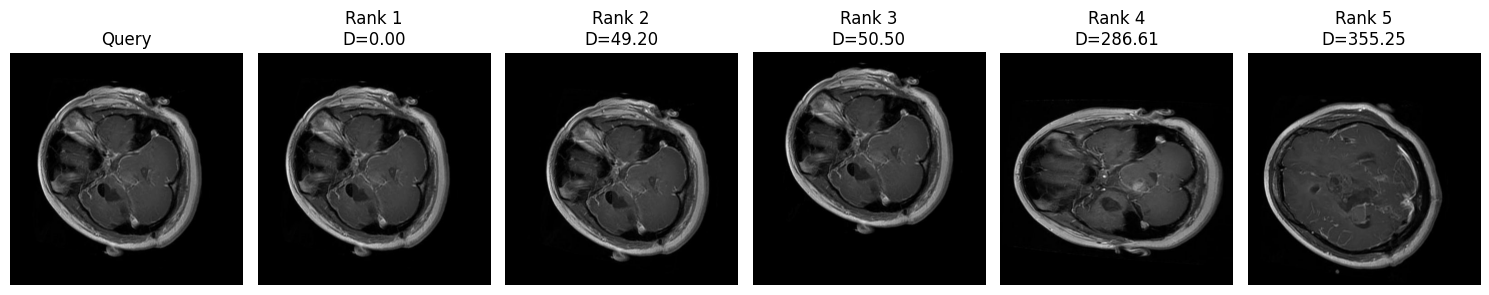

[ERRORE] Matrice di covarianza non invertibile. Uso pseudoinversa.

Top 7 immagini più simili (Mahalanobis): Part1/brain_glioma/brain_glioma_0005.jpg
1. brain_glioma_0005.jpg | Classe: brain_glioma | Distanza: 0.00
2. brain_glioma_0071.jpg | Classe: brain_glioma | Distanza: 8.52
3. brain_glioma_0258.jpg | Classe: brain_glioma | Distanza: 9.34
4. brain_glioma_0767.jpg | Classe: brain_glioma | Distanza: 17.61
5. brain_tumor_0369.jpg | Classe: brain_tumor | Distanza: 19.65
6. brain_glioma_0491.jpg | Classe: brain_glioma | Distanza: 20.40
7. brain_glioma_0169.jpg | Classe: brain_glioma | Distanza: 20.50


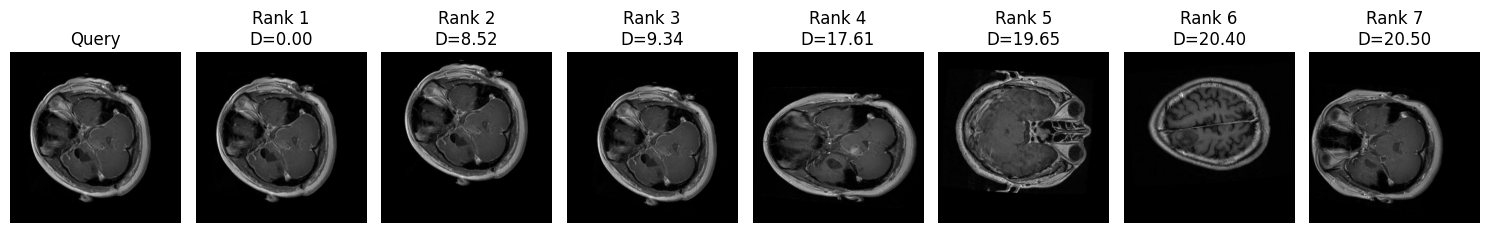

In [21]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# Carica dati da file .npz
data = np.load("features_cm10x10.npz", allow_pickle=True)
feature_matrix = data["features"]
filenames = data["filenames"]
labels = data["labels"]

# === Funzione per trovare k immagini più simili ===
def find_k_similar(img_path, k):
    query_feature = extract_color_moments(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    # Calcola distanza euclidea verso tutte le immagini
    distances = euclidean_distances(feature_matrix, query_feature).flatten()

    # Ordina per distanza crescente
    top_k_idx = np.argsort(distances)[:k]
    top_k_scores = distances[top_k_idx]

    print(f"\nTop {k} immagini più simili a: {img_path}")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Distanza: {top_k_scores[rank]:.2f}")

    # Visualizza
    fig, axs = plt.subplots(1, k+1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        match_img = cv2.imread(os.path.join("Part1", labels[idx], filenames[idx]))
        axs[i+1].imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(f"Rank {i+1}\nD={top_k_scores[i]:.2f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()


def find_k_similar_mahalanobis(img_path, k):
    query_feature = extract_color_moments(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature)

    cov = np.cov(feature_matrix.T)
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        print("[ERRORE] Matrice di covarianza non invertibile. Uso pseudoinversa.")
        cov_inv = np.linalg.pinv(cov)

    distances = np.array([
        mahalanobis(query_feature, f, cov_inv)
        for f in feature_matrix
    ])

    top_k_idx = np.argsort(distances)[:k]
    top_k_scores = distances[top_k_idx]

    print(f"\nTop {k} immagini più simili (Mahalanobis): {img_path}")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {filenames[idx]} | Classe: {labels[idx]} | Distanza: {top_k_scores[rank]:.2f}")

    fig, axs = plt.subplots(1, k+1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        match_img = cv2.imread(os.path.join("Part1", labels[idx], filenames[idx]))
        axs[i+1].imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(f"Rank {i+1}\nD={top_k_scores[i]:.2f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()

# === Test ===
query_img = "Part1/brain_glioma/brain_glioma_0005.jpg"
find_k_similar(query_img, k=5)
find_k_similar_mahalanobis(query_img, k=7)